# YoloV3: Multi-task Face Detection and Facial Landmark Extraction


## Setup

In [ ]:
#!git clone ..
#%cd yolov3

In [13]:
# Import packages
import cv2
import glob
import random
import torch
import numpy as  np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

from models import *
from utils.datasets import *
from utils.utils import *
from hyp import  hyp

from utils.torch_utils import select_device, time_synchronized
from utils.utils import non_max_suppression, xyxy2xywh
from utils.general import scale_coords, plot_one_box, plot_one_landmarks
from utils.inference_datasets import LoadImages, LoadWebcam

In [2]:
def get_model(net_type,  device, weights="", inference=False):
    assert net_type in ["mbv2_1", "mbv2_75"]
    
    if net_type.startswith("mbv2_1"):
        backbone = mobilenet_v2(pretrained=False, width_mult = 1.0)
    elif net_type.startswith("mbv2_75"):
        backbone = mobilenet_v2(pretrained=False, width_mult = 0.75)   
    elif opt.net.startswith("darknet53"):
        backbone = DarkNet53()

    if 'light' in net_type:
        net = DarknetWithShh(backbone, hyp, light_head=True).to(device)
    else:
        net = DarknetWithShh(backbone, hyp).to(device)
    print(net)
    
    if weights:
        net.load_state_dict(torch.load(weights, map_location=device)['model'])
        
    if inference:
        net.eval()
        
    return net

## Training

In [ ]:
resume = False
epochs = 250
batch_size = 16
weights = ""              # initial training weights
backbone_weights = ""
img_size = [640]*3
train_path = "/home/sefa/data/widerface/train/yololandmark_wider_train/"   # Path to training dataset
optim = "adam"
multi_scale_training = True

In [ ]:
def train(hyp):

    accumulate = max(round(64 / batch_size), 1)  # accumulate n times before optimizer update (bs 64)

    imgsz_min, imgsz_max, imgsz_test = img_size  # img sizes (min, max, test)

    # Image Sizes
    gs = 64  # (pixels) grid size
    assert math.fmod(imgsz_min, gs) == 0, '--img-size %g must be a %g-multiple' % (imgsz_min, gs)
    multi_scale_training |= imgsz_min != imgsz_max  # multi if different (min, max)
    if multi_scale_training:
        if imgsz_min == imgsz_max:
            imgsz_min //= 1.5
            imgsz_max //= 0.667
        grid_min, grid_max = imgsz_min // gs, imgsz_max // gs
        imgsz_min, imgsz_max = int(grid_min * gs), int(grid_max * gs)
    img_size = imgsz_max  # initialize with max size

    # Configure run
    init_seeds()

    # Initialize model
    model = get_model(net_type,  device)

    # Optimizer
    pg0, pg1, pg2 = [], [], []  # optimizer parameter groups
    for k, v in dict(model.named_parameters()).items():
        if '.bias' in k:
            pg2 += [v]  # biases
        elif 'Conv2d.weight' in k:
            pg1 += [v]  # apply weight_decay
        else:
            pg0 += [v]  # all else

    if optim == "adam":
        hyp['lr0'] *= 0.1  # reduce lr (i.e. SGD=5E-3, Adam=5E-4)
        optimizer = optim.Adam(pg0, lr=hyp['lr0'])
    else:
        optimizer = optim.SGD(pg0, lr=hyp['lr0'], momentum=hyp['momentum'], nesterov=True)
        
    optimizer.add_param_group({'params': pg1, 'weight_decay': hyp['weight_decay']})  # add pg1 with weight_decay
    optimizer.add_param_group({'params': pg2})  # add pg2 (biases)
    print('Optimizer groups: %g .bias, %g Conv2d.weight, %g other' % (len(pg2), len(pg1), len(pg0)))
    del pg0, pg1, pg2

    start_epoch = 0
    best_fitness = 0.0
    
    # Load pretrained weights if exists
    if weights.endswith('.pt'):  
        chkpt = torch.load(weights, map_location=device)

        # load model
        try:
            chkpt['model'] = {k: v for k, v in chkpt['model'].items() if model.state_dict()[k].numel() == v.numel()}
            model.load_state_dict(chkpt['model'], strict=False)
        except KeyError as e:
            print("Weights could not be loaded!")
            pass
        
        if resume:
            # load optimizer
            if chkpt['optimizer'] is not None:
                optimizer.load_state_dict(chkpt['optimizer'])
                best_fitness = chkpt['best_fitness']

            # load results
            if chkpt.get('training_results') is not None:
                with open(results_file, 'w') as file:
                    file.write(chkpt['training_results'])  # write results.txt

            start_epoch = chkpt['epoch'] + 1
        del chkpt


    # Scheduler https://arxiv.org/pdf/1812.01187.pdf
    lf = lambda x: (((1 + math.cos(x * math.pi / epochs)) / 2) ** 1.0) * 0.95 + 0.05  # cosine
    scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
    scheduler.last_epoch = start_epoch - 1  # see link below

    # Load dataset
    dataset = LoadImagesAndLabels(train_path, img_size, batch_size,
                                  augment=True,
                                  hyp=hyp,  # augmentation hyperparameters
                                  rect=opt.rect,  # rectangular training
                                  cache_images=opt.cache_images,
                                  single_cls=opt.single_cls,
                                  point_number=hyp['point_num'],
                                  flip_idx_pair=hyp['flip_idx_pair']
                                  )

    # Create dataloader
    batch_size = min(batch_size, len(dataset))
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             num_workers=nw,
                                             shuffle=not opt.rect,  # Shuffle=True unless rectangular training is used
                                             pin_memory=True,
                                             collate_fn=dataset.collate_fn)


    # Model parameters
    model.hyp = hyp  # attach hyperparameters to model
    model.gr = 1.0  # giou loss ratio (obj_loss = 1.0 or giou)


    # Model EMA
    ema = torch_utils.ModelEMA(model)

    # Start training
    nb = len(dataloader)  # number of batches
    n_burn = max(3 * nb, 500)  # burn-in iterations, max(3 epochs, 500 iterations)

    # torch.autograd.set_detect_anomaly(True)
    results = (0, 0, 0, 0, 0, 0, 0)  # 'P', 'R', 'mAP', 'F1', 'val GIoU', 'val Objectness', 'val Classification'
    best_total_loss = np.inf
    t0 = time.time()
    print('Image sizes %g - %g train, %g test' % (imgsz_min, imgsz_max, imgsz_test))
    print('Using %g dataloader workers' % nw)
    print('Starting training for %g epochs...' % epochs)
    
    for epoch in range(start_epoch, epochs):  
        model.train()

        mloss = torch.zeros(5).to(device)  # mean losses
        print(('\n' + '%10s' * 10) % ('Epoch', 'gpu_mem', 'GIoU', 'obj', 'cls','land' , 'total', 'targets', 'img_size','lr'))
        pbar = tqdm(enumerate(dataloader), total=nb)  # progress bar
        for i, (imgs, targets, paths, _) in pbar: 
            ni = i + nb * epoch  # number integrated batches (since train start)
            imgs = imgs.to(device).float() / 255.0

            targets = targets.to(device)

            # Burn-in
            if ni <= n_burn:
                xi = [0, n_burn]  # x interp
                model.gr = np.interp(ni, xi, [0.0, 1.0])  # giou loss ratio (obj_loss = 1.0 or giou)
                accumulate = max(1, np.interp(ni, xi, [1, 64 / batch_size]).round())
                for j, x in enumerate(optimizer.param_groups):
                    # bias lr falls from 0.1 to lr0, all other lrs rise from 0.0 to lr0
                    x['lr'] = np.interp(ni, xi, [0.1 if j == 2 else 0.0, x['initial_lr'] * lf(epoch)])
                    x['weight_decay'] = np.interp(ni, xi, [0.0, hyp['weight_decay'] if j == 1 else 0.0])
                    if 'momentum' in x:
                        x['momentum'] = np.interp(ni, xi, [0.9, hyp['momentum']])

            # Multi-Scale
            if multi_scale_training:
                if ni / accumulate % 1 == 0:  #  adjust img_size (67% - 150%) every 1 batch
                    img_size = random.randrange(grid_min, grid_max + 1) * gs
                sf = img_size / max(imgs.shape[2:])  # scale factor
                if sf != 1:
                    ns = [math.ceil(x * sf / gs) * gs for x in imgs.shape[2:]]  # new shape (stretched to 32-multiple)
                    imgs = F.interpolate(imgs, size=ns, mode='bilinear', align_corners=False)

            # Forward
            pred = model(imgs)

            # Loss computation
            loss, loss_items = compute_loss(pred, targets, model,point_number=hyp['point_num'])
            if not torch.isfinite(loss):
                print('WARNING: non-finite loss, ending training ', loss_items)
                return results

            loss *= batch_size / 64  # scale loss
            
            # Backpropagation
            loss.backward()

            # Optimizer
            if ni % accumulate == 0:
                optimizer.step()
                optimizer.zero_grad()
                ema.update(model)

            # Print training results
            mloss = (mloss * i + loss_items) / (i + 1)  # update mean losses
            mem = '%.3gG' % (torch.cuda.memory_cached() / 1E9 if torch.cuda.is_available() else 0)  # (GB)

            s = ('%10s' * 2 + '%10.3g' * 7 + "%10.5g") % ('%g/%g' % (epoch, epochs - 1), mem, *mloss, len(targets), img_size,scheduler.get_lr()[0])
            pbar.set_description(s)


        # Update scheduler
        scheduler.step()

        # Process epoch results
        ema.update_attr(model)
        final_epoch = epoch + 1 == epochs



        chkpt = {'epoch': epoch,
                 'best_fitness': best_fitness,
                 'model': ema.ema.module.state_dict() if hasattr(model, 'module') else ema.ema.state_dict(),
                 'optimizer': None if final_epoch else optimizer.state_dict()}

        # Save last, best and final checkpoints
        torch.save(chkpt, "{}/{}_last.pt".format(wdir, opt.net))
        
        total_loss = mloss.cpu().numpy().sum()
        if total_loss < best_total_loss:
            torch.save(chkpt, "{}/{}_best.pt".format(wdir, opt.net))
        
        
        if  final_epoch:
            torch.save(chkpt, "{}/{}_final.pt".format(wdir,opt.net))

        del chkpt

## Inference

In [3]:
def detect_faces(image, conf_thres=0.4, img_size=640):
    org_shape = image.shape
    img = letterbox(image, new_shape=img_size)[0]

    # Convert
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to CxHXW
    img = np.ascontiguousarray(img)
    img = img.astype(np.float64)
    
    img = torch.from_numpy(img).to(device).float()

    img /= 255.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)

    t1 = time_synchronized()
    pred = model(img)[0]

    pred = non_max_suppression(pred,conf_thres, 0.35,
                               multi_label=False, classes=0, agnostic= False,land=True ,point_num=point_num)

    t2 = time_synchronized()

    # Postprocess detections
    dets = []
    for i, det in enumerate(pred):  # detections per image
        if len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], org_shape).round()
            det[:, 5:5+point_num*2] = scale_coords(img.shape[2:], det[:, 5:5+point_num*2], org_shape).round()
            dets.append(det.detach().cpu().numpy())
            
    return np.array(dets)

Choose an image folder, a net type and a weight file for inference.

In [4]:
image_folder = "../data/inputs/images/"
net_type = "mbv2_1"
weights = f"../weights/{net_type}_last.pt"

In [19]:
device = '0' if torch.cuda.is_available() else 'cpu'
device='cpu'
          
device = select_device(device)
model = get_model(net_type, device, weights, inference=True)

Using CPU

[32, 96, 160]
DarknetWithShh(
  (backbone): MobileNetV2(
    (feature_2): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 

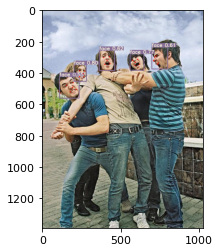

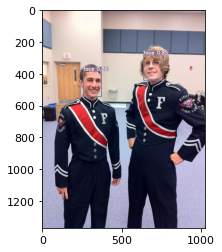

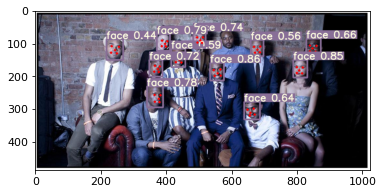

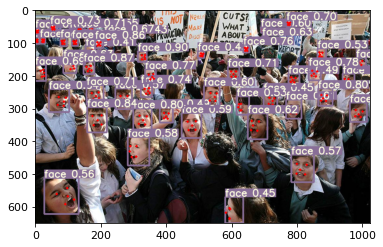

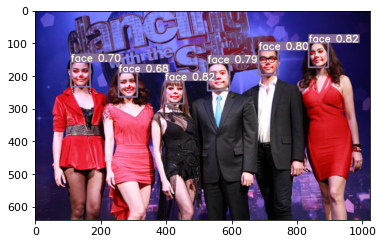

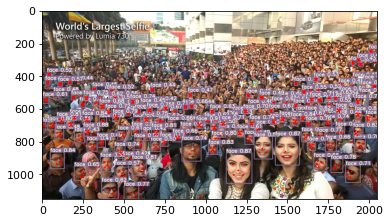

In [14]:
point_num = hyp['point_num']
names = ["face", "no_face"]
colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
image_exts = ['jpg', 'png', 'jpeg']

file_paths = sorted(glob.glob(os.path.join(image_folder, '*.*'))) 
image_paths = [x for x in file_paths if x.split('.')[-1].lower() in image_exts]

for image_path in image_paths:
    image = cv2.imread(image_path)
    predictions = detect_faces(image, conf_thres=0.4, img_size=640)[0]
    
    # Show results on images
    for (*bbox, conf), (*landmarks,cls) in zip(reversed(predictions[:, :5]), reversed(predictions[:, 5:])):
        label = f'{names[int(cls)]} {conf:.2f}'
        plot_one_box(bbox, image, label=label, color=colors[int(cls)], line_thickness=3)
        plot_one_landmarks(landmarks, image)
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(image)

## Inference

## Results

## Training